In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import VotingClassifier
from pandas.plotting import scatter_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
import seaborn as sns
from scipy.stats import norm
import xgboost as xgb

In [2]:
train = pd.read_csv(r'train.csv')
test = pd.read_csv(r'test.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.shape

(891, 12)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


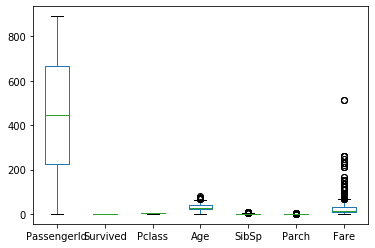

In [6]:
train.plot(kind='box')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025C6C433080>,
      dtype=object)

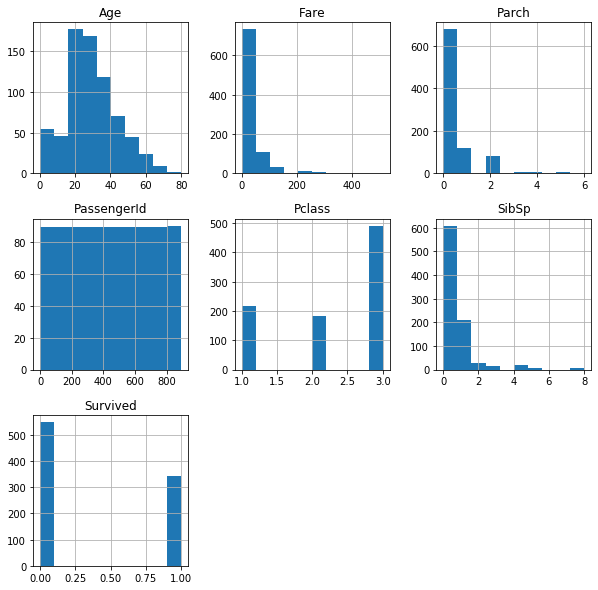

In [7]:
train.hist(figsize= (10,10))

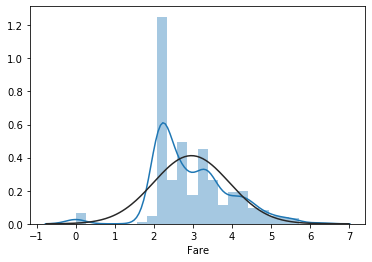

In [8]:
# np.log(train['Fare']+1).plot.hist()
sns.distplot(np.log(train['Fare']+1), fit = norm)

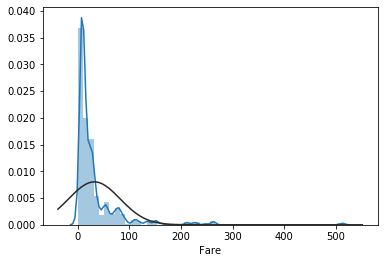

In [9]:
sns.distplot(train['Fare'], fit = norm)

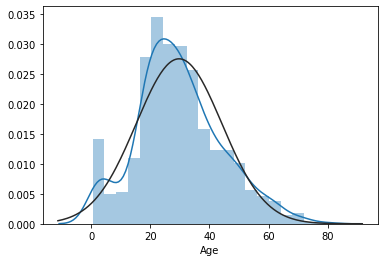

In [10]:
sns.distplot(train['Age'].dropna(), fit = norm)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025C6CBFC198>,
      dtype=object)

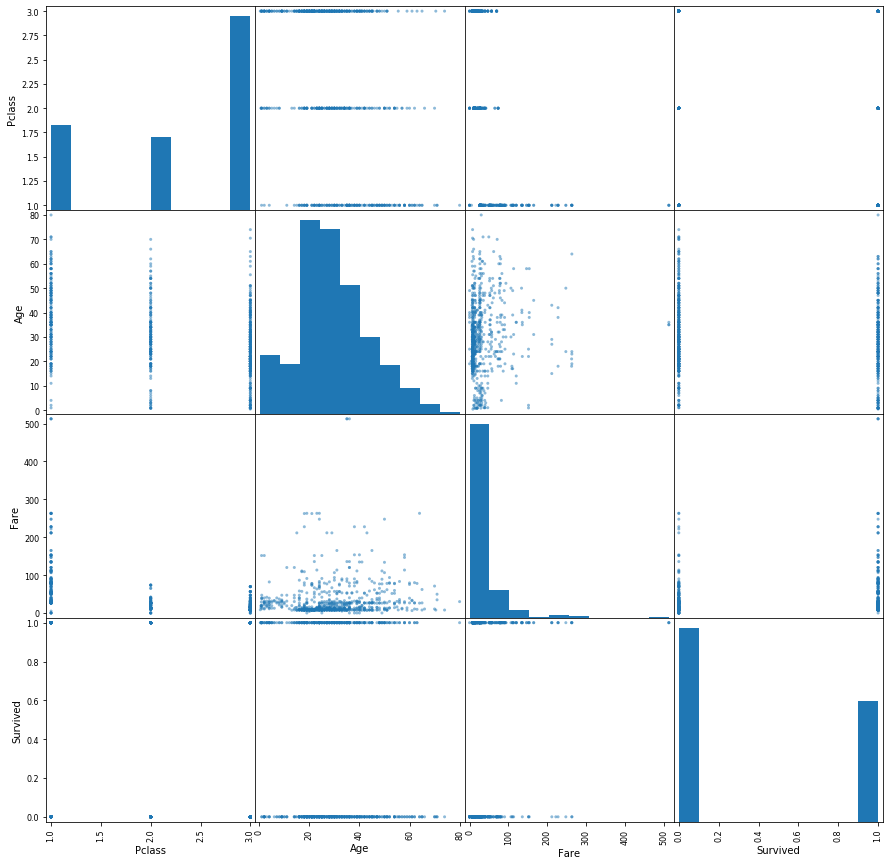

In [11]:
attributes = ['Pclass', 'Age', 'Fare', 'Survived']
scatter_matrix(train[attributes], figsize = (15,15))

In [12]:
class logtransform(BaseEstimator, TransformerMixin):
    def __init__(self, categories):
        self.categories = categories
    def fit(self, X):
        return self
    def transform(self, X):
        if str(type(X)) == "<class 'pandas.core.frame.DataFrame'>":
            return np.log(X[self.categories]+1).values
        return np.log(X+1)
        
class getcategories(logtransform):
    def transform(self, X):
        return X[self.categories].values

In [13]:
categorical = ['Embarked', 'Sex']
numerical = ['Age','Pclass']
lognumerical = ['SibSp', 'Parch', 'Fare']
label = train['Survived'].values #.reshape(-1,1).ravel()

cat_features = Pipeline([
    ('getcat', getcategories(categorical)),
    ('inputter', SimpleImputer(strategy = 'constant', fill_value='0')),
    ('onehot', OneHotEncoder())
])

num_features = Pipeline([
    ('getcat', getcategories(numerical)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('standardscale', StandardScaler())
])

log_numerical = Pipeline([
    ('getcat', getcategories(lognumerical)),
    ('imputer', SimpleImputer(strategy = 'median')),
    ('logtransform', logtransform(lognumerical)),
    ('standard_scale', StandardScaler())
])

full_pipe = FeatureUnion(transformer_list=[
    ('numerical', num_features),
    ('log_numerical', log_numerical),
    ('cat_features', cat_features)
])

# classifier =getcategories(lognumerical)
x = full_pipe.fit_transform(train)
x.shape

(891, 11)

In [14]:


list_scores = []
kf = KFold(n_splits = 10)
classifier = LogisticRegression()
for train_set, test_set in kf.split(x):
    x_train, x_test = x[train_set], x[test_set]
    y_train, y_test = label[train_set], label[test_set]
    classifier.fit(x_train,y_train)
    list_scores.append(classifier.score(x_test, y_test))
np.array(list_scores).mean()

C:\Users\Paulo Abalos\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7834207240948814

In [15]:
parameters = [
    {'fit_intercept': [True, False], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
]

gridsearch = GridSearchCV(classifier, parameters,cv=10, scoring = 'accuracy' )
gridsearch.fit(x,label)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'fit_intercept': [True, False],
                          'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                     'saga']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [16]:
gridsearch.best_params_

{'fit_intercept': True, 'solver': 'newton-cg'}

In [17]:
gridsearch.best_score_

0.7878787878787878

In [18]:
list(zip(gridsearch.cv_results_['params'], gridsearch.cv_results_['mean_test_score']))

[({'fit_intercept': True, 'solver': 'newton-cg'}, 0.7878787878787878),
 ({'fit_intercept': True, 'solver': 'lbfgs'}, 0.7878787878787878),
 ({'fit_intercept': True, 'solver': 'liblinear'}, 0.7878787878787878),
 ({'fit_intercept': True, 'solver': 'sag'}, 0.7878787878787878),
 ({'fit_intercept': True, 'solver': 'saga'}, 0.7878787878787878),
 ({'fit_intercept': False, 'solver': 'newton-cg'}, 0.7878787878787878),
 ({'fit_intercept': False, 'solver': 'lbfgs'}, 0.7878787878787878),
 ({'fit_intercept': False, 'solver': 'liblinear'}, 0.7878787878787878),
 ({'fit_intercept': False, 'solver': 'sag'}, 0.7878787878787878),
 ({'fit_intercept': False, 'solver': 'saga'}, 0.7878787878787878)]

In [31]:
xgclassifier = xgb.XGBRFClassifier()

scores = cross_val_score(xgclassifier, X=x, y=label ,scoring='accuracy')

C:\Users\Paulo Abalos\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [32]:
scores.mean()

0.8148148148148149

In [ ]:
xgclassifier.score()

In [ ]:
list_scores2 = []
kf = KFold(n_splits=10)
classifier2 = KNeighborsClassifier(n_neighbors=5)
for train_set, test_set in kf.split(x):
    x_train, x_test = x[train_set], x[test_set]
    y_train, y_test = label[train_set], label[test_set]
    classifier2.fit(x_train,y_train)
    list_scores2.append(classifier2.score(x_test, y_test))
np.array(list_scores2).mean()

In [30]:
classifier3 = SVC(gamma='scale')

cross_val_score(classifier3, X= x, y=label, cv=10).mean()

0.8249526160481215

In [ ]:
classifier4 = VotingClassifier([('svc',classifier3),('knn',classifier2),('logreg',classifier)])

cross_val_score(classifier4,X= x, y=label, cv=10).mean()